In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
from src import drawing_functions as df
import plot_functions as pf

colors={}

colors['physics']='#c73b0b'
colors['052012-theoretical-physics']='#c73b0b'

colors['startups']='#BEAA6F'
colors['122013-answers-onstartups']='#BEAA6F'

colors['math']='#6C9584'
colors['mathematica']='#6C9584'

folder_path = 'data/processed data/'

communities = ["physics", "astronomy", "052012-theoretical-physics", "052012astronomy", 
               "052012economics", "052012-literature", "literature", "economics", 
               "startups","122013-answers-onstartups", "math", "mathematica"] 

# dictionaries to keep dataframes for all communities:
data_questions = {}
data_rep_agg = {}
data_nets = {}
data_coreper = {}

for comm in communities:
    # active questions data
    # aggragated data about dynamical reputations:
    data_questions[comm] = pd.read_csv(folder_path+'active questions/%s_weekly_active_questions.csv'%(comm))
    data_rep_agg[comm] = pd.read_csv(folder_path+'%s_dynamic_reputation_aggregates.csv'%(comm))
    # interaction networks + dynamical reputations data:
    data_nets[comm] = pd.read_csv(folder_path+'%s_dyn_rep_and_networks_features.csv'%(comm))
    # core periphery data:
    data_coreper[comm] = pd.read_csv(folder_path+'%s_dyn_rep_and_core_periphery_features.csv'%(comm))
    
#define path to save figures
save_path = "data/figures/"
os.makedirs(save_path, exist_ok=True)

### Compare Physics with Mathemtics (top row) and Mathematica (bottom row). 
All these communities graduated in the first year. As reference we plot the closed Theoretical Physics.

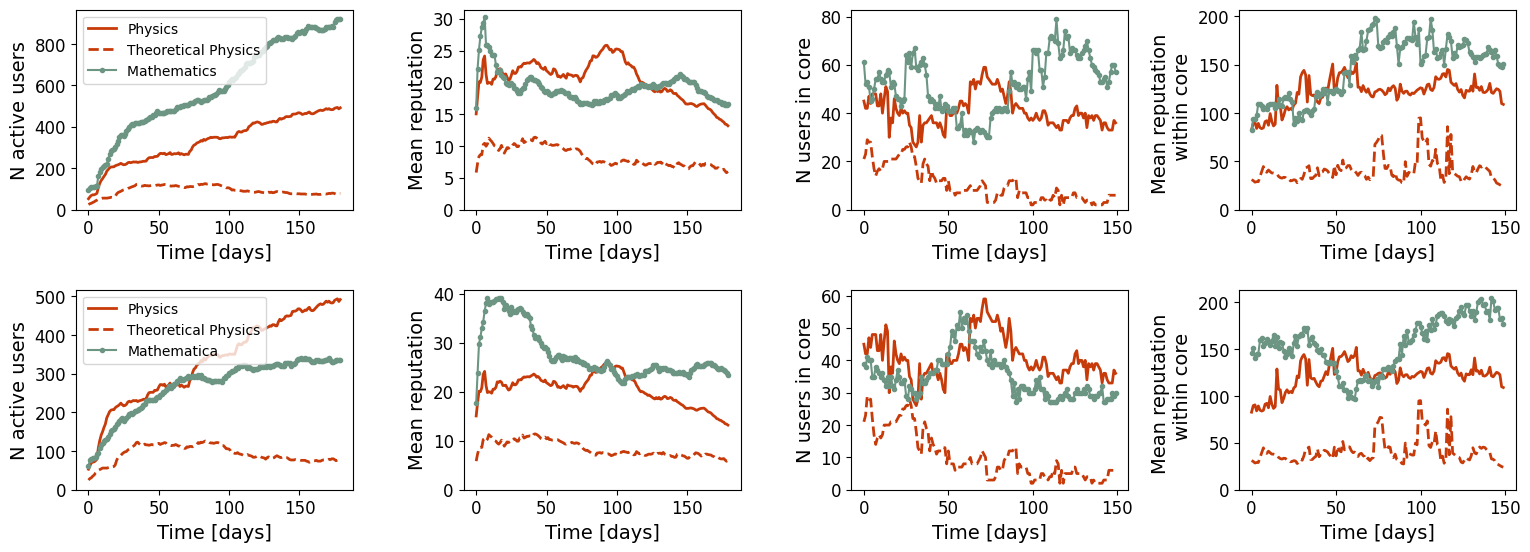

In [2]:
pf.comparestartups_2rows(data_rep_agg, data_coreper, "physics", "math", "mathematica", colors,  legendtext1=["Physics", "Theoretical Physics", "Mathematics "], 
                         legendtext2=["Physics", "Theoretical Physics", "Mathematica"])
plt.savefig(save_path+'FigA15.pdf', dpi=300, bbox_inches='tight')
plt.savefig(save_path+'FigA15.png', dpi=300, bbox_inches='tight')

### Compare Physics with Startups (top row) and Startups Business (bottom row). 
The Startups community was closed and it behaved similar to closed Theoretical Physics. The Startups Business were also closed, even though their number of users were high, and had large core. 

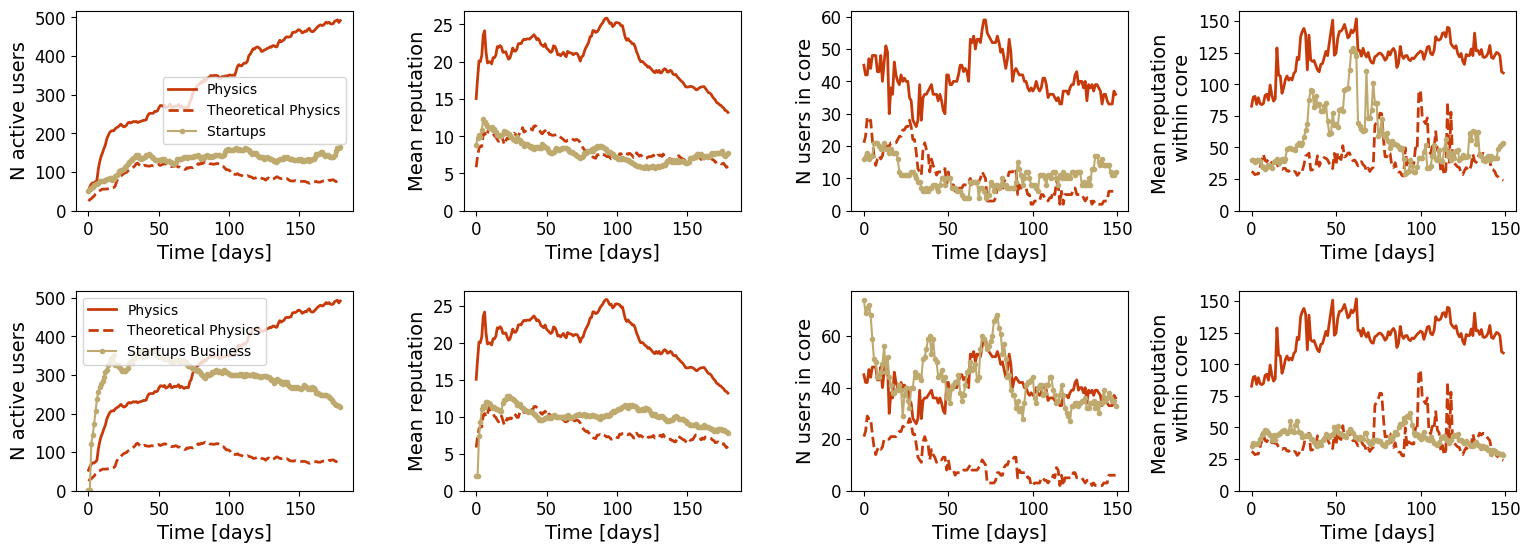

In [4]:
pf.comparestartups_2rows(data_rep_agg, data_coreper, "physics", "startups", "122013-answers-onstartups", colors,  legendtext1=["Physics", "Theoretical Physics", "Startups "], 
                         legendtext2=["Physics", "Theoretical Physics", "Startups Business"])
plt.savefig(save_path+'FigA16.pdf', dpi=300, bbox_inches='tight')
plt.savefig(save_path+'FigA16.png', dpi=300, bbox_inches='tight')

## Clustering
Compare clustering of SE communities with expected values in Erdos-Reny and Barabasi-Albert networks with same number of links and nodes as in original subnetwork

In [6]:
import pandas as pd
import networkx as nx
import numpy as np

# this function caclulates the clustering of each 30day network
def clustering(community, data_path, twin=30):
    
    data = {"First_day":[],
            "N_nodes":[],
            "Links":[],
            "clustering":[],
            "clustering_ER":[],
            "clustering_BA":[],
    }

    # import interactions via questions, answers and comments for network:
    interactions_path = data_path+'interactions/'
    qa = pd.read_csv(interactions_path + '%s/%s_interactions_questions_answers.csv'%(community,community))
    comm = pd.read_csv(interactions_path + '%s/%s_interactions_comments.csv'%(community,community))
    acc = pd.read_csv(interactions_path + '%s/%s_interactions_acc_answers.csv'%(community,community))

    for t in range(180-twin):
                
        # interaction slices within [t,t+twin) windows
        qna_slice = qa[(qa['days']>=t)&(qa['days']<t+twin)].dropna().copy()#ast had nan's so dropna is included
        comm_slice = comm[(comm['days']>=t)&(comm['days']<t+twin)].dropna().copy()
        acc_slice = acc[(acc['days']>=t)&(acc['days']<t+twin)].dropna().copy()

        # full network of interactions
        fullnet = pd.concat([qna_slice[['PostUserId','RespondUserId']], comm_slice[['PostUserId','RespondUserId']], acc_slice[['PostUserId','RespondUserId']]])
        fullnet = fullnet[fullnet['PostUserId']!=fullnet['RespondUserId']] #drop selflinks
        network = nx.Graph()
        network = nx.from_pandas_edgelist(fullnet, source='RespondUserId', target='PostUserId')
        network = network.to_undirected()
        
        N = network.number_of_nodes()
        L = network.number_of_edges()
        
        if N!=0:
            clustering_coef = nx.average_clustering(network)
            clustering_er = 2*L/(N*(N-1))
            clustering_ba = 1/16*(2*L/(N*(N-1)))*np.log(N)**2
        else:
            clustering_coef = 0
            clustering_er = 0
            clustering_ba = 0
            
        
        # network's mean clustering coef.

        data["First_day"].append(t)
        data["N_nodes"].append(N)
        data["Links"].append(L)
        data["clustering"].append(clustering_coef)
        data["clustering_ER"].append(clustering_er)
        data["clustering_BA"].append(clustering_ba)
        

    df = pd.DataFrame(data)
    return df

#get clustering for each community

data = {}
communities = ["physics", "052012-theoretical-physics", "astronomy", "052012astronomy", "literature", "052012-literature", "economics", "052012economics", 
              "math", "mathematica", "startups", "122013-answers-onstartups"]
for name in communities:
    #print(name)
    df = clustering(name, "./data/")
    data[name]=df

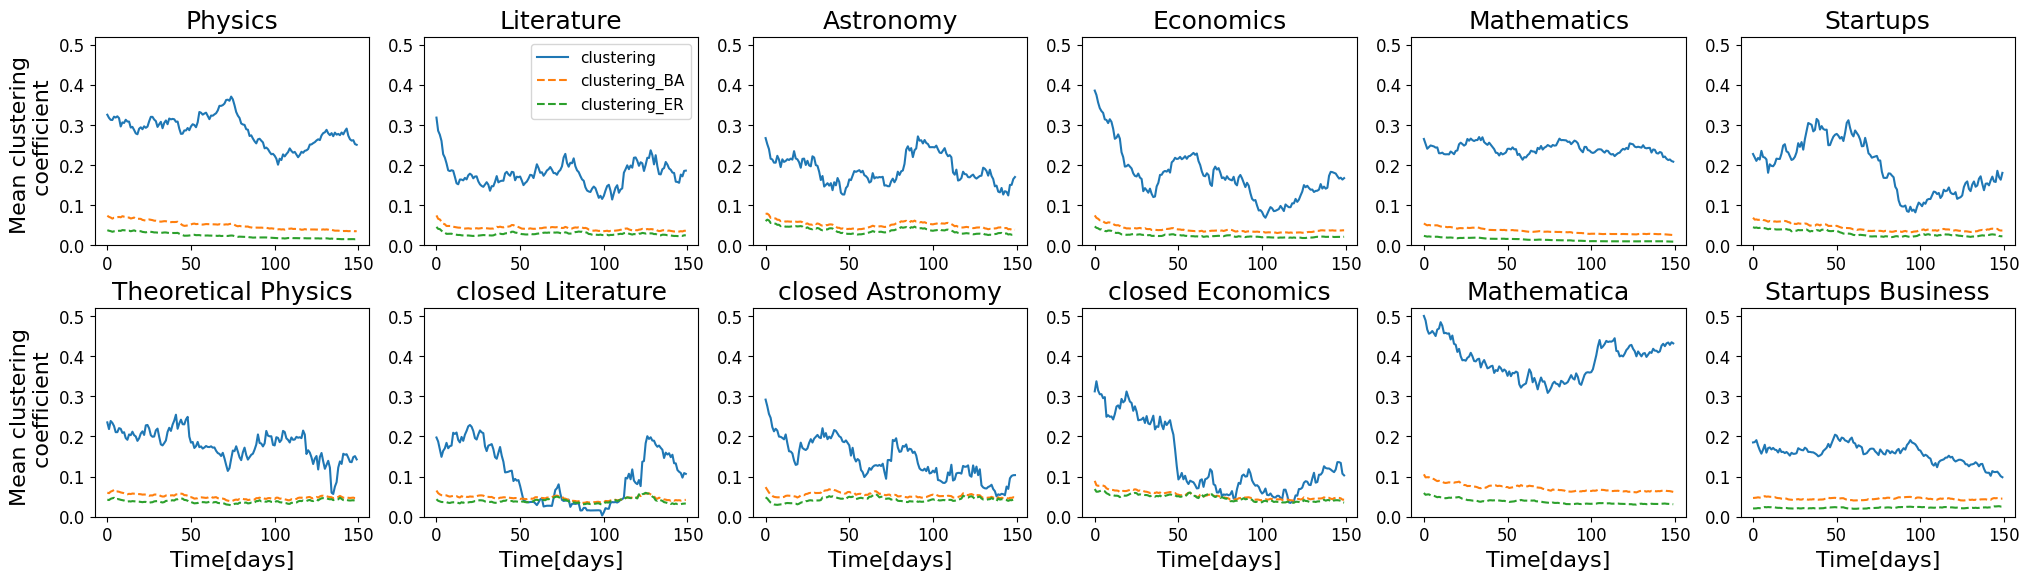

In [37]:
import matplotlib.pyplot as plt

def plot_graph(data, name):
    plt.plot(data[name]["clustering"], label="clustering")
    plt.plot(data[name]["clustering_BA"],"--", label="clustering_BA")
    plt.plot(data[name]["clustering_ER"], "--", label="clustering_ER")
    plt.legend(fontsize=11)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0, 0.52)
    
communities = ["physics", "literature",  "astronomy", "economics", "math",   "startups",
               "052012-theoretical-physics", "052012-literature", "052012astronomy", "052012economics",  "mathematica",   "122013-answers-onstartups"]

titles = {"physics": "Physics", "math": "Mathematics", "literature":"Literature", "economics":"Economics", "astronomy":"Astronomy", "startups":"Startups",
               "052012-theoretical-physics":"Theoretical Physics", "mathematica":"Mathematica", "052012-literature":"closed Literature",
          "052012economics":"closed Economics", "052012astronomy": "closed Astronomy", "122013-answers-onstartups": "Startups Business"}

A=2
B=6
i=1

plt.figure(figsize = (4*B,3*A))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.2,hspace=0.3)
for comm in communities:
    plt.subplot(A, B, i)
    plot_graph(data, comm)
    plt.title(titles[comm], fontsize=18)
    if i!=2:  plt.legend().set_visible(False)
    if i==1 or i==7:
        plt.ylabel("Mean clustering \n coefficient", fontsize=16)
    if i>6:
        plt.xlabel("Time[days]", fontsize=16)
    i+=1

plt.savefig(save_path+'FigA17.png', dpi=300, bbox_inches='tight')